# Inspect network quality

- Inspect OSM network quality
- Inspect Pandana CostMatrix paths between origin-destination pairs
- - Know Pandana made some bugs in Costmatrix for Øst police district


In [10]:
# import watermark
%reload_ext watermark
%watermark

Last updated: 2024-03-22T12:38:17.325889+01:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.22.2

Compiler    : MSC v.1935 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import shapely
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, mapping
from pyproj import Transformer
import geopandas as gpd
import osmnx as ox
import networkx as nx
import pandana as pdna
import pulp

pd.set_option('display.float_format', lambda x: '%.3f' % x)
ox.settings.log_console=True
ox.settings.use_cache=True
%watermark -w
%watermark -iv

Watermark: 2.4.3

pandana   : 0.7
geopandas : 0.14.3
networkx  : 3.2.1
shapely   : 2.0.3
matplotlib: 3.8.3
pulp      : 2.8.0
numpy     : 1.26.4
pandas    : 2.2.1
osmnx     : 1.9.1



## 1. Load the data
### 1.1 Load road network

We load a road network that has been slightly preprocessed.
- Network type: drive
- CRS: WGS84 EPSG:4326, will be converted to UTM33N EPSG:32633
- Network already contains edge weights (travel time in seconds)
- Node closeness centrality has already been calculated for the network and stored as a CSV file.

For all input data we change the CRS from WGS84 to UTM33N. This is done to make the distance calculations easier.

In [12]:
### Load road network file of Øst police district, Norway
# Read from local path
ost_filepath = "../data/ost/OstDriveImputed.graphml" # with travel time attribute
ost_graph = ox.load_graphml(ost_filepath) # originally in WGS84 (EPSG:4326)

In [13]:
ost_graph = ox.projection.project_graph(ost_graph, to_crs='EPSG:32633') # if need to project to UTM zone 33N
print(f"Type of ost_graph: {type(ost_graph)}")
print(f"CRS of ost_graph:  {ost_graph.graph['crs']}")

# plot graph
# fig, ax = ox.plot_graph(ost_graph, node_size=1, edge_linewidth=0.2, edge_color="w", bgcolor="k")

Type of ost_graph: <class 'networkx.classes.multidigraph.MultiDiGraph'>
CRS of ost_graph:  EPSG:32633


In [14]:
# INSPECT NETWORK QUALITY # 
is_multigraph = ost_graph.is_multigraph()
print(f"Is the network a multigraph? {is_multigraph}")
is_connected = nx.is_connected(ost_graph.to_undirected())
print(f"Is the network connected? {is_connected}")
is_planar = nx.check_planarity(ost_graph)
print(f"Is the network planar? {is_planar}")
is_tree = nx.is_tree(ost_graph)
print(f"Is the network a tree? {is_tree}")
is_dag = nx.is_directed_acyclic_graph(ost_graph)
print(f"Is the network a DAG? {is_dag}")
isolated_nodes = list(nx.isolates(ost_graph))

print(f"Number of isolated nodes: {len(isolated_nodes)}")
self_loops = list(nx.nodes_with_selfloops(ost_graph))
print(f"Number of self-loops: {len(self_loops)}")
connected_components = nx.number_connected_components(ost_graph.to_undirected())
print(f"Number of connected components: {connected_components}")
strongly_connected_components = nx.number_strongly_connected_components(ost_graph)
print(f"Number of strongly connected components: {strongly_connected_components}")
weakly_connected_components = nx.number_weakly_connected_components(ost_graph)
print(f"Number of weakly connected components: {weakly_connected_components}")

Is the network a multigraph? True
Is the network connected? True
Is the network planar? (False, None)
Is the network a tree? False
Is the network a DAG? False
Number of isolated nodes: 0
Number of self-loops: 513
Number of connected components: 1
Number of strongly connected components: 64
Number of weakly connected components: 1


In [15]:
# Identify the weakly connected components by printing their IDs
weakly_connected_components = list(nx.weakly_connected_components(ost_graph))
# print(f"IDs of weakly connected components: {weakly_connected_components}")

# print what the weakly connected components consist of
for i, c in enumerate(weakly_connected_components):
    print(f"Component {i} has {len(c)} nodes")
    print(c)

Component 0 has 47948 nodes
{9056419852, 2012741646, 5788008464, 2962096150, 2962096153, 2012741660, 2012741664, 2012741670, 2012741682, 4487512115, 9056419892, 2012741685, 619184182, 1602748466, 1602748471, 1602748473, 2012741691, 4797997222, 8638300232, 8638300235, 9056419916, 619184208, 2012741720, 619184218, 2639790174, 619184229, 2639790187, 2639790196, 619184249, 2012741755, 5478547581, 2639790206, 5146017923, 2012741767, 6984958097, 3623354517, 1303773337, 5851447450, 2012741785, 1303773340, 5851447453, 5788008614, 6984958127, 2012741813, 2012741817, 1303773371, 1303773380, 619184327, 5818941641, 6174802127, 619184335, 8638300371, 331874518, 619184343, 5818941656, 331874520, 1303773398, 2639790296, 2012741850, 6984958176, 368312544, 2012741866, 619184367, 331874546, 1303773434, 619184380, 619184382, 7641104638, 6984958209, 639107331, 368312584, 1303773449, 2012741897, 368312585, 1303773453, 8638300431, 331874580, 1303773460, 2639790357, 8638300439, 331874586, 8638300443, 3318745

In [16]:
# # Check if the graph is strongly connected
is_strongly_connected = nx.is_strongly_connected(ost_graph)
print(f"Is the network strongly connected? {is_strongly_connected}")

# If not, then check if the graph is weakly connected
is_weakly_connected = nx.is_weakly_connected(ost_graph)
print(f"Is the network weakly connected? {is_weakly_connected}")

# The meaning of weakly connected is that there is a path between all pairs of nodes in the graph, but the direction of the edges is ignored.

# then identify what parts of the graph are weakly connected
if is_weakly_connected:
    weakly_connected_components = list(nx.weakly_connected_components(ost_graph))
    print(f"IDs of weakly connected components: {weakly_connected_components}")

    # print what the weakly connected components consist of
    for i, c in enumerate(weakly_connected_components):
        print(f"Component {i} has {len(c)} nodes")
        print(c)
    
strongly_connected_components = list(nx.strongly_connected_components(ost_graph))
print(f"Type of weakly_connected_components: {type(weakly_connected_components)}")

Is the network strongly connected? False
Is the network weakly connected? True
IDs of weakly connected components: [{9056419852, 2012741646, 5788008464, 2962096150, 2962096153, 2012741660, 2012741664, 2012741670, 2012741682, 4487512115, 9056419892, 2012741685, 619184182, 1602748466, 1602748471, 1602748473, 2012741691, 4797997222, 8638300232, 8638300235, 9056419916, 619184208, 2012741720, 619184218, 2639790174, 619184229, 2639790187, 2639790196, 619184249, 2012741755, 5478547581, 2639790206, 5146017923, 2012741767, 6984958097, 3623354517, 1303773337, 5851447450, 2012741785, 1303773340, 5851447453, 5788008614, 6984958127, 2012741813, 2012741817, 1303773371, 1303773380, 619184327, 5818941641, 6174802127, 619184335, 8638300371, 331874518, 619184343, 5818941656, 331874520, 1303773398, 2639790296, 2012741850, 6984958176, 368312544, 2012741866, 619184367, 331874546, 1303773434, 619184380, 619184382, 7641104638, 6984958209, 639107331, 368312584, 1303773449, 2012741897, 368312585, 1303773453, 8

Convert graph to GeoDataFrame and plot it.   
`osmnx.utils_graph.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)` - Convert a MultiDiGraph to node and/or edge GeoDataFrames.

In [17]:
# converting the graph network to node and edge GeoPandas GeoDataFrames
nodes, edges = ox.graph_to_gdfs(ost_graph, nodes=True, edges=True)
print(f"type of nodes:{type(nodes)}")
# nodes.head()
edges.head(2) # verify edges contain speed and travel time

type of nodes:<class 'geopandas.geodataframe.GeoDataFrame'>


osmid  \
u         v          key                                      
265629056 8595477415 0    [629271201, 120466454, 926242999]   
          8595512022 0               [926242773, 110781343]   

                                                 name       highway  oneway  \
u         v          key                                                      
265629056 8595477415 0    [Storesandveien, Vadholmen]  unclassified   False   
          8595512022 0                      Storveien       primary   False   

                         reversed   length  \
u         v          key                     
265629056 8595477415 0       True 1061.374   
          8595512022 0      False  435.557   

                                                                   geometry  \
u         v          key                                                      
265629056 8595477415 0    LINESTRING (271942.408 6550299.054, 271939.667...   
          8595512022 0    LINESTRING (271942.408 6550299.054, 271945.319...   

                          speed_kph  travel_time  ref  maxspeed bridge  \
u         v          key                                                 
265629056 8595477415 0       40.100       95.300  NaN       NaN    NaN   
          8595512022 0       50.000       31.400  108  [40, 60]    NaN   

                         junction lanes tunnel width access est_width  
u         v          key                                               
265629056 8595477415 0        NaN   NaN    NaN   NaN    NaN       NaN  
          8595512022 0        NaN   NaN    NaN   NaN    NaN       NaN

In [18]:
edges.columns

Index(['osmid', 'name', 'highway', 'oneway', 'reversed', 'length', 'geometry',
       'speed_kph', 'travel_time', 'ref', 'maxspeed', 'bridge', 'junction',
       'lanes', 'tunnel', 'width', 'access', 'est_width'],
      dtype='object')

## 2. Add police car locations

In [19]:
# random nodes from the graph
SEED = 2
NR_OF_CAR_NODES = 10
car_nodes = nodes.sample(NR_OF_CAR_NODES, random_state=SEED) # sample X random source nodes
print(f"Total nr of nodes: {len(nodes)}, nr of police car nodes: {len(car_nodes)}")

# make car_nodes into a GeoDataFrame
car_nodes_gdf = gpd.GeoDataFrame(car_nodes, geometry=gpd.points_from_xy(car_nodes.x, car_nodes.y))
car_nodes_gdf_filtered = car_nodes_gdf
car_nodes_gdf_filtered.head(2)

Total nr of nodes: 47948, nr of police car nodes: 10


,y,x,street_count,lon,lat,highway,ref,geometry
osmid,,,,,,,,
4455422778,6607499.119,294809.721,3,11.369,59.555,NaN,NaN,POINT (294809.721 6607499.119)
1906496665,6670411.910,269384.138,4,10.850,60.106,NaN,NaN,POINT (269384.138 6670411.910)


## 3. Add simulated events

In [20]:
# load preprocessed population data and convert to CRS UTM zone 33N (EPSG:32633)
ost_polygon_path = "../data/ost/OstCombinedPolygon.geojson"
population_path = "../data/ost/OstPopulation.geojson"
ost_polygon_gdf = gpd.read_file(ost_polygon_path)
population_gdf = gpd.read_file(population_path)
ost_polygon_gdf = ost_polygon_gdf.to_crs(ost_graph.graph['crs']) # convert to same CRS as the road network
population_gdf = population_gdf.to_crs(ost_graph.graph['crs']) # convert to same CRS as the road network
print(f"type of pop_df: {type(population_gdf)}")
print(f"columns of population_gdf: {population_gdf.columns}")
population_gdf.head(2)

type of pop_df: <class 'geopandas.geodataframe.GeoDataFrame'>
columns of population_gdf: Index(['id', 'population', 'geometry'], dtype='object')


,id,population,geometry
0,22735006545750,4,"POLYGON ((273500.000 6545750.000, 273500.000 6..."
1,22737506546000,2,"POLYGON ((273750.000 6546000.000, 273750.000 6..."


In [21]:
def simulate_event_points(population_gdf, min_range=2000, max_range=2500):
    """
    Simulates the number of event points in each gridcell based on its population count.
    Use a binary search algorithm to find the optimal population multiplier to achieve a target number of points.
    Target range for the total number of points is defined by [min_target, max_target].    
    """
    # Define the target range for the total number of points
    min_target = min_range
    max_target = max_range
    
    # Initial lower and upper bounds for population_multiplier
    low = 0.001
    high = 0.01
    
    # Convergence threshold and maximum iterations to prevent infinite loops
    epsilon = 1e-6
    max_iterations = 100
    iteration = 0
    while iteration < max_iterations:
        mid = (low + high) / 2
        
        # Calculate the number of points using the current guess of population_multiplier
        population_gdf['num_points'] = np.round(mid * population_gdf['population']).astype(int)
        population_gdf['num_points'] = np.maximum(population_gdf['num_points'], 0) # Ensure non-negative
        total_points = population_gdf['num_points'].sum()
        
        # Check if the total number of points is within the target range
        if min_target <= total_points <= max_target:
            print(f"Total number of simulated event points: {total_points}. Target range [{min_target}, {max_target}], using population multiplier: {mid}")
            break
        elif total_points < min_target:
            low = mid
        else:
            high = mid
        
        # Check for convergence
        if abs(high - low) < epsilon:
            print(f"Convergence reached with multiplier: {mid} (total points: {total_points})")
            break
        iteration += 1
    
    if iteration == max_iterations:
        print(f"Max iterations reached with multiplier: {mid} (total points: {total_points})")

    return population_gdf

In [22]:
# calculate the number of points to simulate in each grid cell - vectorized version
population_gdf = simulate_event_points(population_gdf, min_range=100, max_range=200)

# print the number of cells with 0, 1, 2, ..., 9 events
for i in range(0, 10):
    print(f"Nr of cells with {i} events: {len(population_gdf[population_gdf['num_points'] == i])}")

# print the cells with the highest number of points
population_gdf.nlargest(3, 'num_points')

Total number of simulated event points: 175. Target range [100, 200], using population multiplier: 0.0015625
Nr of cells with 0 events: 24894
Nr of cells with 1 events: 168
Nr of cells with 2 events: 2
Nr of cells with 3 events: 1
Nr of cells with 4 events: 0
Nr of cells with 5 events: 0
Nr of cells with 6 events: 0
Nr of cells with 7 events: 0
Nr of cells with 8 events: 0
Nr of cells with 9 events: 0


,id,population,geometry,num_points
17847,22735006649250,1697,"POLYGON ((273500.000 6649250.000, 273500.000 6...",3
6398,22740006649000,1147,"POLYGON ((274000.000 6649000.000, 274000.000 6...",2
17843,22737506649000,1186,"POLYGON ((273750.000 6649000.000, 273750.000 6...",2


In [23]:
%%time
# Function to generate points within a grid cell
def generate_points_within_gridcell(num_points, bounds):
    """Generate points within given bounds."""
    min_x, min_y, max_x, max_y = bounds
    xs = np.random.uniform(min_x, max_x, num_points)
    ys = np.random.uniform(min_y, max_y, num_points)
    points = [Point(x, y) for x, y in zip(xs, ys)]
    return points

# List to hold all generated points
event_points = []
# Iterate over rows in your GeoDataFrame
for _, row in population_gdf.iterrows():
    # Extract number of points to generate for the current row
    num_points = row['num_points']
    if num_points > 0:  # Proceed only if there are points to generate
        # Generate points within the grid cell
        points = generate_points_within_gridcell(num_points, row['geometry'].bounds)
        event_points.extend(points)

# Create a GeoDataFrame from the generated points
event_points_gdf = gpd.GeoDataFrame(geometry=event_points, crs=population_gdf.crs)
event_points_gdf.head(3)

CPU times: total: 1.28 s
Wall time: 1.72 s


,geometry
0,POINT (270954.812 6570640.169)
1,POINT (268254.839 6570055.270)
2,POINT (269935.655 6569818.975)


In [24]:
# # 2 subplots side-by-side of population density and simulated event points
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
# vmin, vmax = 0, 200
# ost_polygon_gdf.boundary.plot(ax=ax1, color='black', linewidth=0.5, alpha=0.7)
# population_gdf.plot(ax=ax1, column='population', cmap='Reds', legend=True, alpha=0.7, vmin=vmin, vmax=vmax)
# ax1.get_xaxis().set_visible(False)
# ax1.get_yaxis().set_visible(False)
# ax1.set_title('Population density')

# ost_polygon_gdf.boundary.plot(ax=ax2, color='black', linewidth=0.5, alpha=0.7)
# event_points_gdf.plot(ax=ax2, color='red', markersize=10, alpha=0.7, edgecolor='black', lw=0.5)
# ax2.get_xaxis().set_visible(False)
# ax2.get_yaxis().set_visible(False)
# ax2.set_title('Simulated event points')
# print(f"Total number of simulated event points: {len(event_points_gdf)}")
# plt.tight_layout(); plt.show()

## 4. Define Pandana network


In [25]:
# reset index so our origins and destinations are not in index
edges = edges.reset_index()

# create network with pandana
ost_network_pdna = pdna.Network(node_x=nodes['x'], node_y=nodes['y'], edge_from=edges['u'], edge_to=edges['v'], 
                                      edge_weights=edges[["length", "travel_time"]], twoway=True)

# Print stats about the network
print(f"type of ost_network_pdna: {type(ost_network_pdna)}")
print(f"Network nodes:")
ost_network_pdna.nodes_df.head(2)

type of ost_network_pdna: <class 'pandana.network.Network'>
Network nodes:


,x,y
osmid,,
265629056,271942.408,6550299.054
8595477415,271187.495,6549913.134


In [16]:
print(f"Network edges: ")
ost_network_pdna.edges_df.head(2)

Network edges: 


,from,to,length,travel_time
0,265629056,8595477415,1061.374,95.300
1,265629056,8595512022,435.557,31.400


In [17]:
%%time
# ost_network_pdna.precompute(3000)

CPU times: total: 0 ns
Wall time: 0 ns


In [18]:
# identify nearest node to each event point
event_points_gdf['nearest_node'] = ost_network_pdna.get_node_ids(event_points_gdf.geometry.x, event_points_gdf.geometry.y, mapping_distance=1000)

# With nearest_node attribute, find osm x,y coordinates
event_points_gdf = event_points_gdf.merge(nodes[['x', 'y']], left_on='nearest_node', right_index=True, suffixes=('', '_nearest_node'))
event_points_gdf.head(2)

,geometry,nearest_node,x,y
0,POINT (270959.729 6570536.149),446363221.000,270946.189,6570586.570
1,POINT (268421.615 6570249.762),14828563.000,268441.046,6570241.479


In [19]:
# Get list of nearest node ids for event locations
event_nodes_pdna = ost_network_pdna.get_node_ids(x_col=event_points_gdf.geometry.x, y_col=event_points_gdf.geometry.y).values
event_nodes_pdna[:5]

# get the nearest node ids (in this case, just selecting the 'osmid')
car_nodes_pdna = ost_network_pdna.get_node_ids(x_col=car_nodes_gdf_filtered.x, y_col=car_nodes_gdf_filtered.y).values
car_nodes_pdna[:5]

array([4455422778, 1906496665, 2027223313,  747169359, 1927811826],
      dtype=int64)

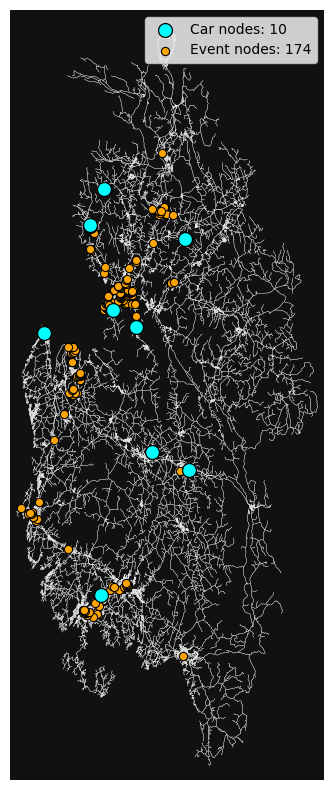

In [20]:
# Plot nodes for overview using ox.plot
fig, ax = ox.plot_graph(ost_graph, node_color="white", node_size=0, edge_linewidth=0.2, edge_color="w", show=False, close=False, figsize=(10,10))
# add number of events and car nodes to the legend
ax.scatter(car_nodes_gdf_filtered['x'], car_nodes_gdf_filtered['y'], c='cyan', edgecolor='black', lw=0.90, s=100, label=f"Car nodes: {len(car_nodes_gdf_filtered)}", zorder=3)
ax.scatter(event_points_gdf['x'], event_points_gdf['y'], c='orange', s=35, edgecolor='black', lw=0.80, label=f"Event nodes: {len(event_points_gdf)}", zorder=2)
ax.legend(); plt.show()

## 5. Cost Matrix

### 5.1 compute Cost Matrix for all origin-destination pairs - using fast Pandana library

In [21]:
# Creating origins-destination pairs
origins = np.repeat(car_nodes_pdna, len(event_nodes_pdna))
destinations = np.tile(event_nodes_pdna, len(car_nodes_pdna))

# for o, d in zip(origins, destinations):
#     print(f"{o}, {d}")

In [22]:
%%time
# distance between each possible pair of facilities-clients combination
distances = ost_network_pdna.shortest_path_lengths(origins, destinations, imp_name='length')
travel_times = ost_network_pdna.shortest_path_lengths(origins, destinations, imp_name='travel_time')

print(type(distances))
print("Number of distances calculated: ", len(distances), "\n")
print("5 first origin-destination distances [m]     :", distances[:5])
print("5 first origin-destination travel times [sec]:", travel_times[:5], "\n")

<class 'list'>
Number of distances calculated:  1740 

5 first origin-destination distances [m]     : [53114.027, 55622.219, 54092.551, 55479.44, 55823.816]
5 first origin-destination travel times [sec]: [2960.1, 3085.4, 2987.1, 3074.9, 3115.7] 

CPU times: total: 156 ms
Wall time: 31.6 ms


In [23]:
# print the statistics for distances and travel times
# print("Distances statistics:")
# print(pd.Series(distances).describe())
print("\nTravel times statistics:")
print(pd.Series(travel_times).describe())


Travel times statistics:
count   1740.000
mean    3214.414
std     1906.116
min      122.300
25%     1598.475
50%     2982.150
75%     4810.200
max     8152.600
dtype: float64


In [24]:
# Restructure the distances and travel times arrays into a DataFrame (Cost Matrix) and add the car and event node ids as columns

# create a DataFrame from the distances and travel times arrays
CostMatrix = pd.DataFrame({'distance': distances, 'travel_time': travel_times})

# add the car and event node ids as columns
CostMatrix['carNodeID'] = np.repeat(car_nodes_pdna, len(event_nodes_pdna))
CostMatrix['eventNodeID'] = np.tile(event_nodes_pdna, len(car_nodes_pdna))
CostMatrix.head(2) # distances, travel times, car and event node ids

,distance,travel_time,carNodeID,eventNodeID
0,53114.027,2960.100,4455422778,446363221
1,55622.219,3085.400,4455422778,14828563


In [25]:
# merge the distances DataFrame with the car and event nodes DataFrames to get the coordinates
CostMatrix_extended = CostMatrix.merge(car_nodes_gdf_filtered, left_on='carNodeID', right_index=True)
CostMatrix_extended = CostMatrix.merge(event_points_gdf, left_on='eventNodeID', right_index=True, suffixes=('_car', '_event'))
CostMatrix_extended.head(2)

,distance,travel_time,carNodeID,eventNodeID,geometry,nearest_node,x,y


### 5.2 Inspect Cost Matrix

For each origin-destination pair, we can inspect the shortest path and the travel time.   
We want to:
- Check if the network distance is reasonable
    - Add another column with the euclidean distance between the origin and destination
    - Calculate the ratio between the shortest network path distance and the euclidean distance
- Decide what ratio is acceptable
- For pairs with unacceptable ratio (computed using pandana)
    - Re-compute the shortest path using networkx
    - Update the distance and travel time in the cost matrix

Finally, inspect the updated Cost matrix again.

In [26]:
# CostMatrix columns are: distance, travel_time, carNodeID, eventNodeID, x_car, y_car, x_event, y_event